# `TBTauModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the `TBTauModel` model. `TBTauModel` is like `TauModel`, except it also predicts the brightness temperature spectra for the 1612, 1665, 1667, and 1720 MHz hyperfine transitions of OH. This notebook is otherwise identical to the `TauModel` notebook.

In [1]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

from amoeba2 import TBTauModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.2+0.g883013c.dirty
amoeba2 version: 1.0.0-staging+0.g61de2dc.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `TBTauModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"tau_1612", "tau_1665", "tau_1667", "tau_1720", "TB_1612", "TB_1665", "TB_1667", and "TB_1720"`.

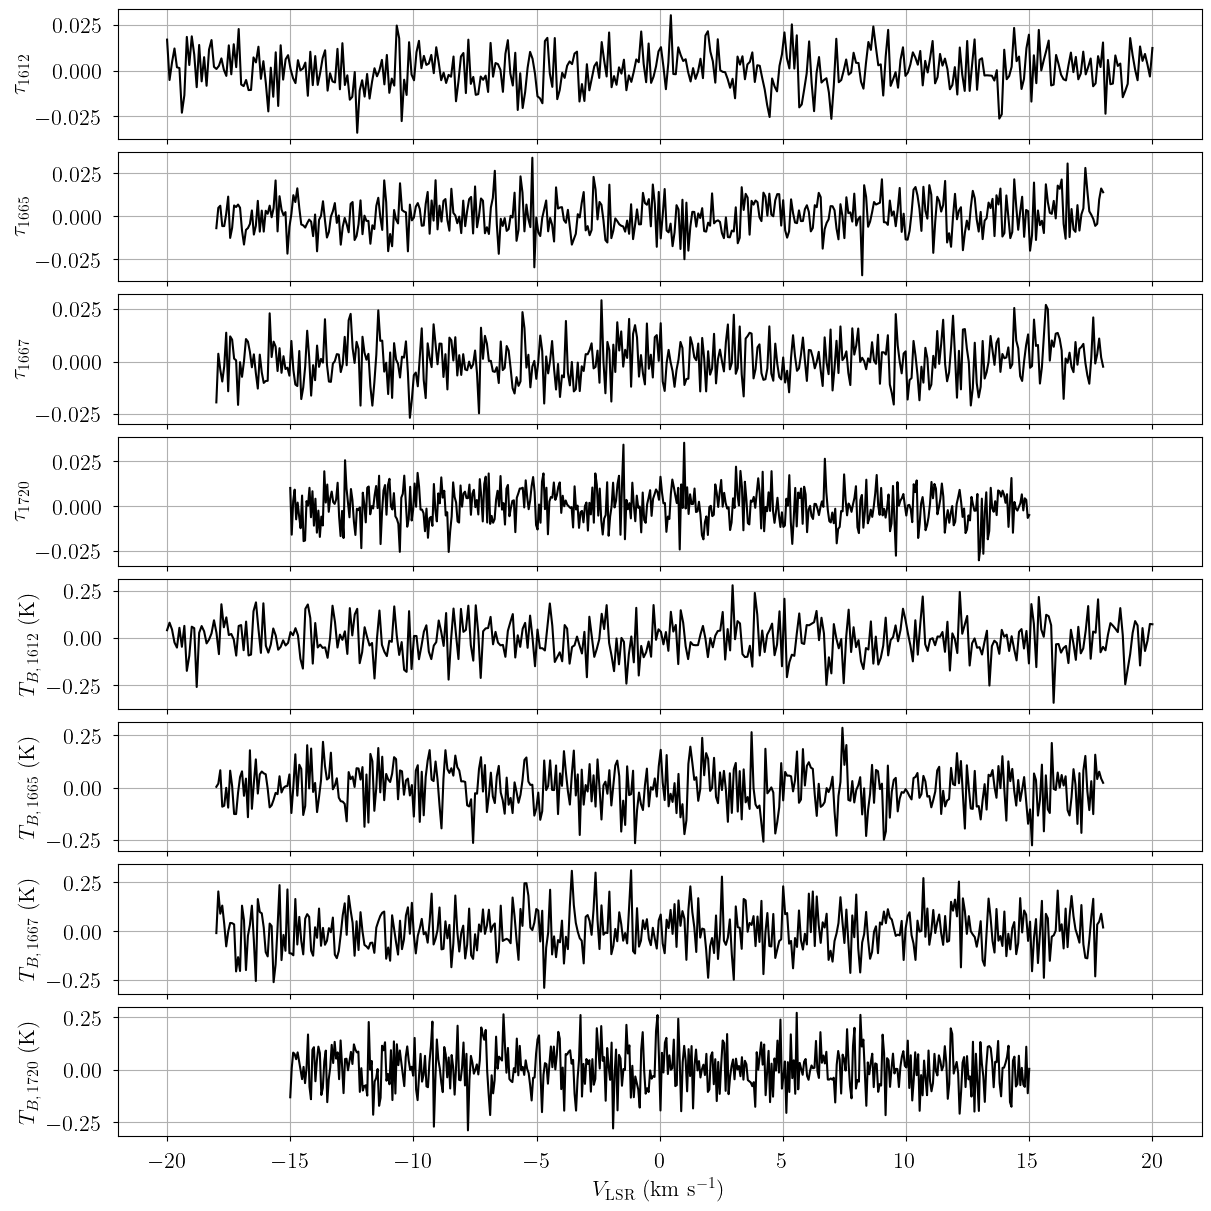

In [3]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_tau = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}
rms_TB = {
    "1612": 0.1,
    "1665": 0.1,
    "1667": 0.1,
    "1720": 0.1,
}

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
tau = {label: rms_tau[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}
TB = {label: rms_TB[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"tau_{label}": SpecData(
        velo_axis[label],
        tau[label],
        rms_tau[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )
    for label in velo_axis.keys()
}
for label in velo_axis.keys():
    dummy_data[f"TB_{label}"] = SpecData(
        velo_axis[label],
        TB[label],
        rms_TB[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_{B,\,"+f"{label}"+r"}$ (K)"
    )

# Plot dummy data
fig, axes = plt.subplots(8, sharex=True, layout="constrained", figsize=(12, 12))
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
_ = axes[-1].set_xlabel(dummy_datum.xlabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [4]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = TBTauModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of spectral rms prior
    prior_rms_TB = 0.1, # width of brightness temperature rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [6]:
# Evaluate likelihood for given model parameters
# excitation temperature for 1612, 1665, and 1667 MHz
inv_Tex_free = np.array([
    [0.2, -0.2, 0.06], # cloud 0
    [0.06, 0.1, 0.2], # cloud 1
    [0.06, 0.06, 0.1] # cloud 2
])

sim_params = {
    "log10_N_0": np.array([14.0, 14.5, 13.5]),
    "inv_Tex_free": inv_Tex_free,
    "fwhm": np.array([1.2, 1.5, 0.8]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
}

data = {}
for i, label in enumerate(velo_axis.keys()):
    # Simulate optical depth
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_tau_{label}_norm"] = np.array([0.0, -1.0, 2.0])
    sim_params_label["rms_tau"] = np.array([0.01, 0.008, 0.012, 0.01])
    tau = model.model[f"tau_{label}"].eval(sim_params_label)
    data[f"tau_{label}"] = SpecData(
        velo_axis[label],
        tau,
        sim_params_label["rms_tau"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )
    
    # Simulate brightness temperature
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_TB_{label}_norm"] = np.array([0.0, -1.0, 2.0])
    sim_params_label[f"rms_TB"] = np.array([0.1, 0.15, 0.15, 0.05])
    TB = model.model[f"TB_{label}"].eval(sim_params_label)
    data[f"TB_{label}"] = SpecData(
        velo_axis[label],
        TB,
        sim_params_label["rms_TB"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_{B,\,"+f"{label}"+r"}$"
    )

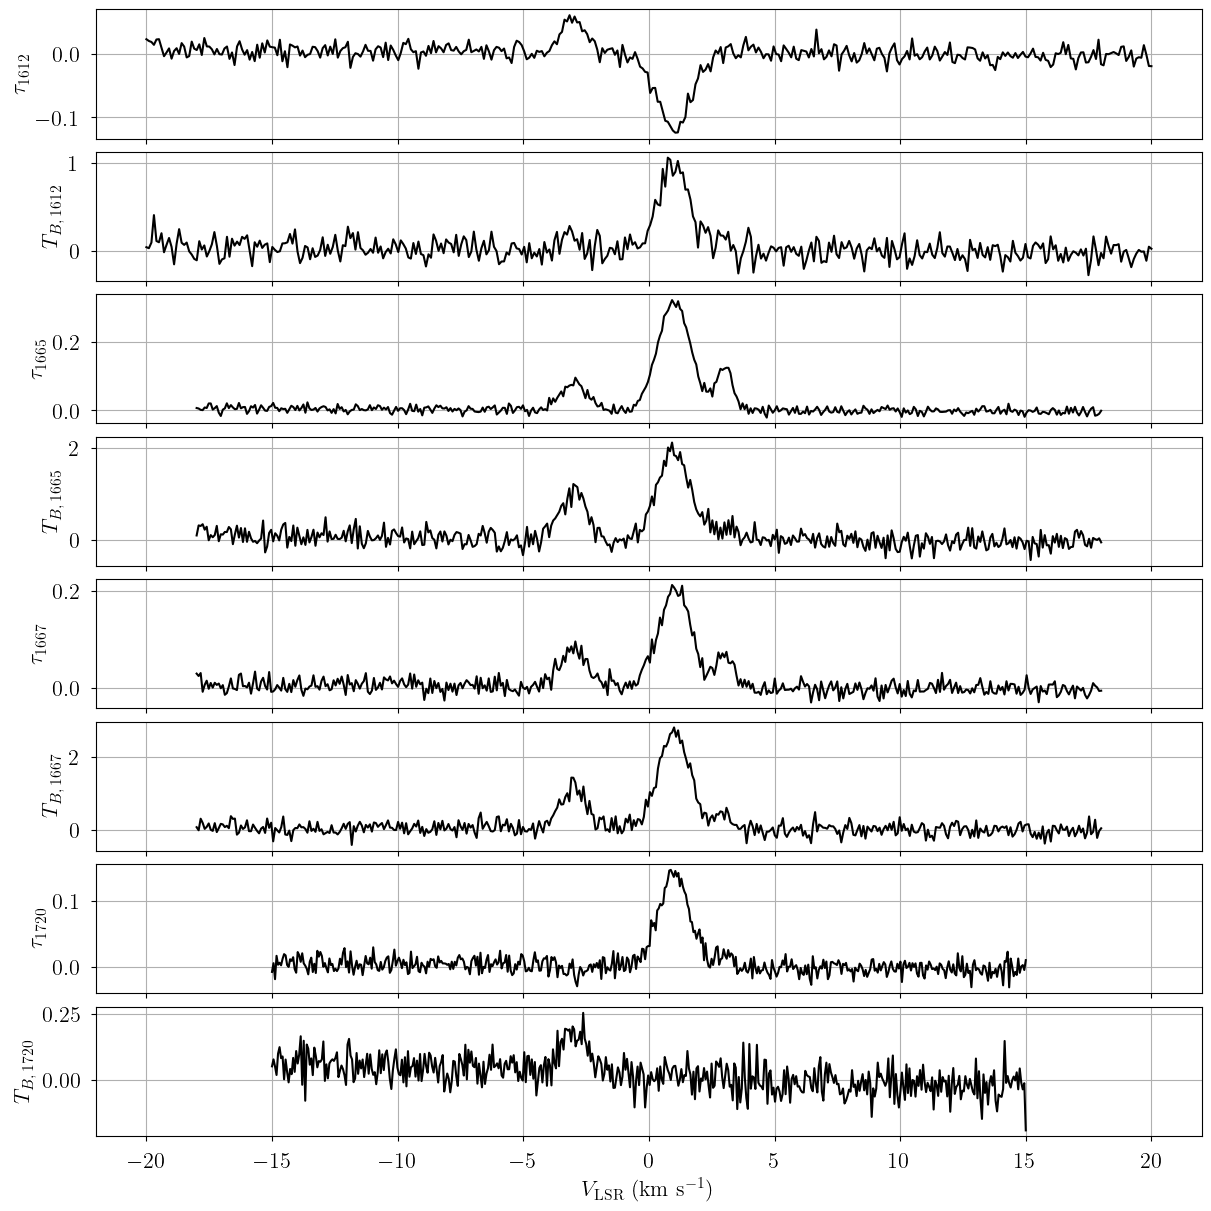

In [7]:
# Plot data
fig, axes = plt.subplots(8, sharex=True, layout="constrained", figsize=(12, 12))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Model Definition

In [8]:
# Initialize and define the model
model = TBTauModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.5, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 1.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of spectral rms prior
    prior_rms_TB = 0.1, # width of brightness temperature rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

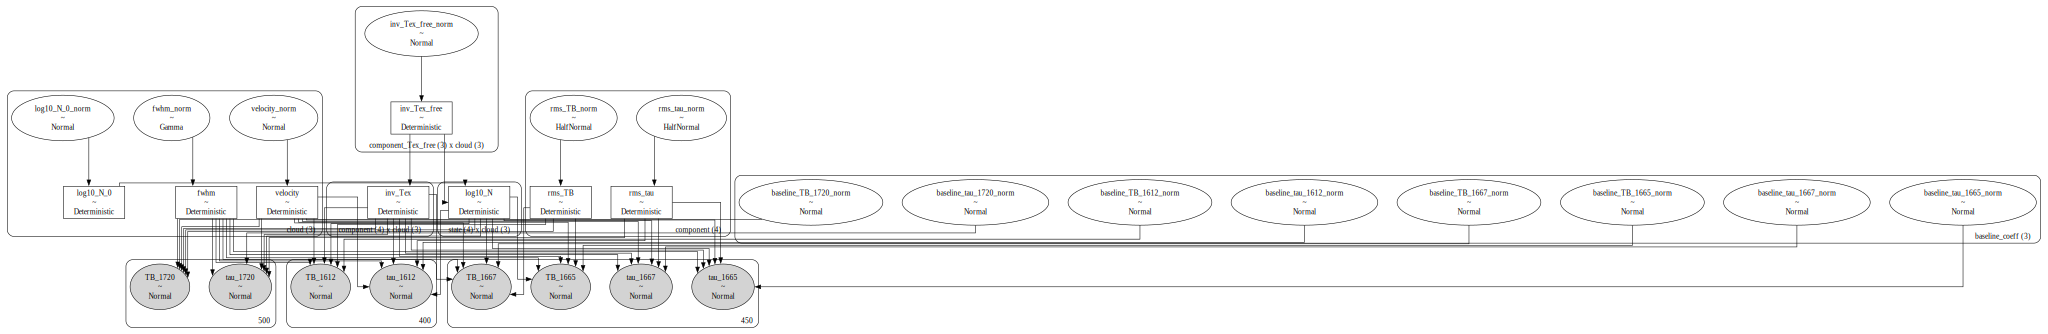

In [20]:
# Plot model graph
gviz = pm.model_to_graphviz(model.model)
gviz.graph_attr["rankdir"] = "TB"
gviz.graph_attr["splines"] = "ortho"
# gviz.graph_attr["newrank"] = "true"
gviz.graph_attr["rank"] = "same"
gviz.graph_attr["ranksep"] = "1.0"
gviz.graph_attr["nodesep"] = "0.5"
gviz.render('tb_tau_model', format='png')
gviz

In [21]:
# model string representation
print(model.model.str_repr())

baseline_tau_1612_norm ~ Normal(0, <constant>)
 baseline_TB_1612_norm ~ Normal(0, <constant>)
baseline_tau_1665_norm ~ Normal(0, <constant>)
 baseline_TB_1665_norm ~ Normal(0, <constant>)
baseline_tau_1667_norm ~ Normal(0, <constant>)
 baseline_TB_1667_norm ~ Normal(0, <constant>)
baseline_tau_1720_norm ~ Normal(0, <constant>)
 baseline_TB_1720_norm ~ Normal(0, <constant>)
        log10_N_0_norm ~ Normal(0, 1)
     inv_Tex_free_norm ~ Normal(0, 1)
             fwhm_norm ~ Gamma(2, f())
         velocity_norm ~ Normal(0, 1)
          rms_tau_norm ~ HalfNormal(0, 1)
           rms_TB_norm ~ HalfNormal(0, 1)
             log10_N_0 ~ Deterministic(f(log10_N_0_norm))
          inv_Tex_free ~ Deterministic(f(inv_Tex_free_norm))
               inv_Tex ~ Deterministic(f(inv_Tex_free_norm))
               log10_N ~ Deterministic(f(log10_N_0_norm, inv_Tex_free_norm))
                  fwhm ~ Deterministic(f(fwhm_norm))
              velocity ~ Deterministic(f(velocity_norm))
               rms_t

Sampling: [TB_1612, TB_1665, TB_1667, TB_1720, baseline_TB_1612_norm, baseline_TB_1665_norm, baseline_TB_1667_norm, baseline_TB_1720_norm, baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, fwhm_norm, inv_Tex_free_norm, log10_N_0_norm, rms_TB_norm, rms_tau_norm, tau_1612, tau_1665, tau_1667, tau_1720, velocity_norm]


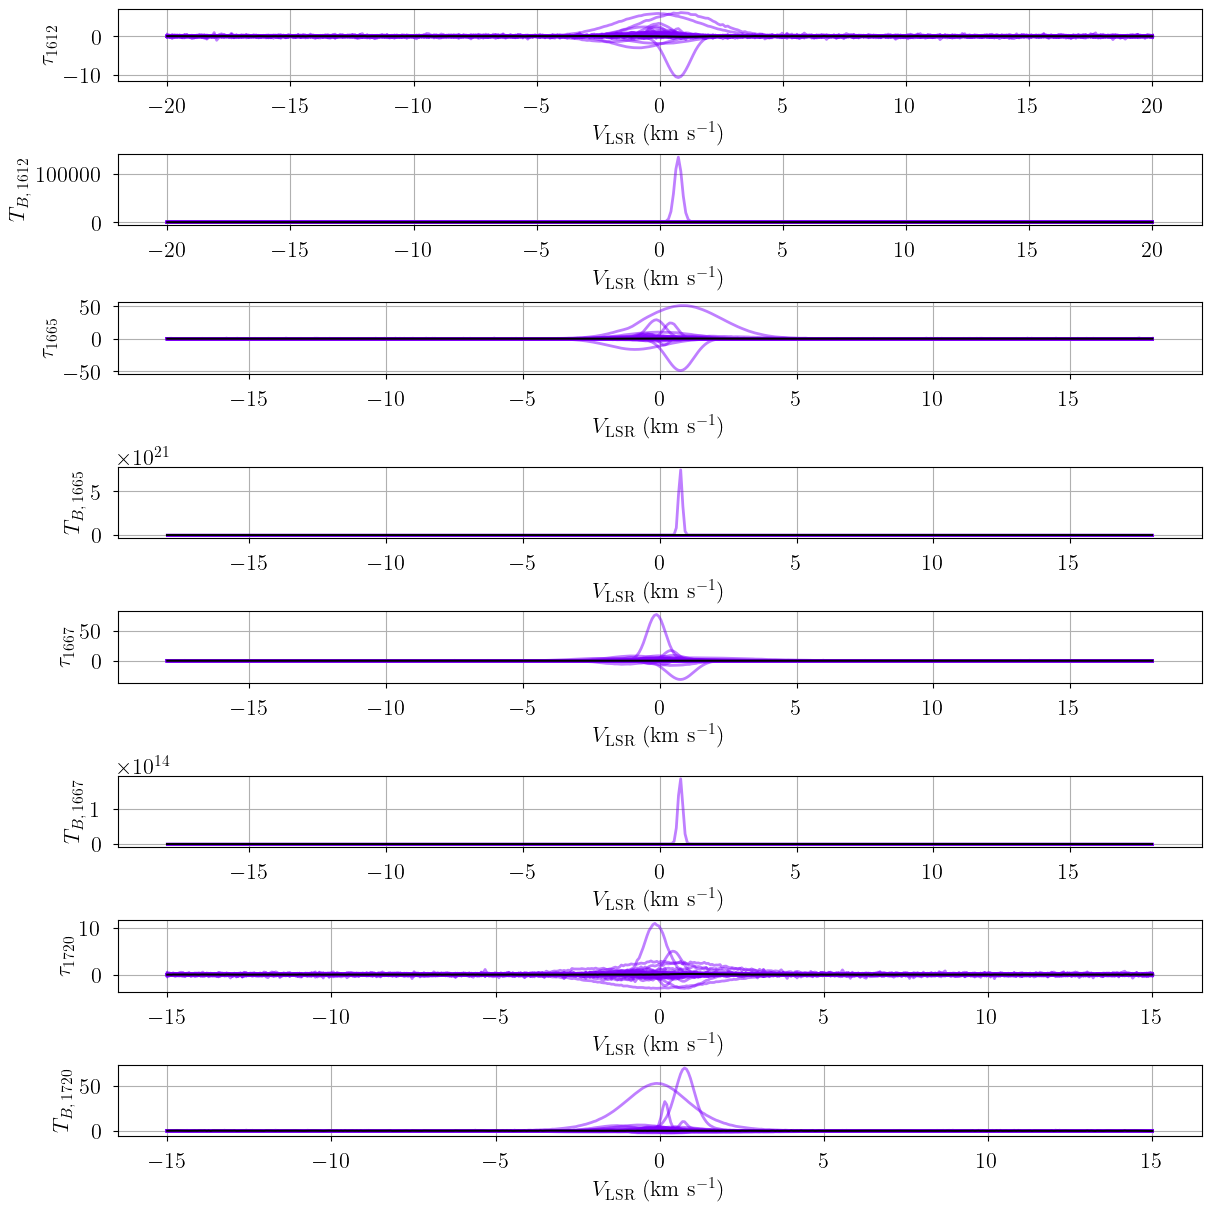

In [22]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [23]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 11,487


Runtime: 2.35 minutes


In [24]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_TB_1612_norm[0]    -0.191  0.031  -0.250   -0.133      0.001   
baseline_TB_1612_norm[1]    -0.469  0.097  -0.650   -0.283      0.003   
baseline_TB_1612_norm[2]    -0.125  0.531  -1.002    0.972      0.016   
baseline_TB_1665_norm[0]    -0.156  0.026  -0.211   -0.113      0.001   
baseline_TB_1665_norm[1]    -0.469  0.089  -0.638   -0.311      0.003   
baseline_TB_1665_norm[2]    -1.656  0.491  -2.613   -0.805      0.015   
baseline_TB_1667_norm[0]    -0.127  0.023  -0.167   -0.083      0.001   
baseline_TB_1667_norm[1]    -0.231  0.077  -0.376   -0.095      0.002   
baseline_TB_1667_norm[2]    -2.471  0.425  -3.235   -1.651      0.013   
baseline_TB_1720_norm[0]     0.062  0.041  -0.011    0.143      0.001   
baseline_TB_1720_norm[1]    -1.704  0.145  -1.959   -1.430      0.005   
baseline_TB_1720_norm[2]    -1.336  0.649  -2.498    0.021      0.021   
baseline_tau_1612_norm[0]    0.272  0.028   0.220    0.321      0.001   
baseline_tau_1612_norm[1]   -0.526  0.095  -0.685   -0.341      0.003   
baseline_tau_1612_norm[2]   -1.440  0.491  -2.397   -0.565      0.015   
baseline_tau_1665_norm[0]   -0.215  0.014  -0.240   -0.189      0.000   
baseline_tau_1665_norm[1]   -0.211  0.046  -0.298   -0.127      0.002   
baseline_tau_1665_norm[2]   -1.624  0.282  -2.132   -1.102      0.009   
baseline_tau_1667_norm[0]   -0.179  0.022  -0.220   -0.134      0.001   
baseline_tau_1667_norm[1]   -0.380  0.078  -0.525   -0.232      0.003   
baseline_tau_1667_norm[2]   -1.964  0.434  -2.757   -1.099      0.014   
baseline_tau_1720_norm[0]   -0.299  0.019  -0.335   -0.265      0.001   
baseline_tau_1720_norm[1]   -0.390  0.058  -0.496   -0.282      0.002   
baseline_tau_1720_norm[2]    0.472  0.338  -0.155    1.079      0.011   
fwhm[0]                      0.709  0.036   0.639    0.773      0.001   
fwhm[1]                      1.456  0.043   1.369    1.527      0.001   
fwhm[2]                      1.469  0.020   1.431    1.508      0.001   
fwhm_norm[0]                 0.709  0.036   0.639    0.773      0.001   
fwhm_norm[1]                 1.456  0.043   1.369    1.527      0.001   
fwhm_norm[2]                 1.469  0.020   1.431    1.508      0.001   
inv_Tex[1612, 0]             0.007  0.047  -0.083    0.091      0.001   
inv_Tex[1612, 1]            -0.281  0.012  -0.306   -0.259      0.000   
inv_Tex[1612, 2]            -0.197  0.010  -0.215   -0.179      0.000   
inv_Tex[1665, 0]             0.266  0.014   0.240    0.293      0.000   
inv_Tex[1665, 1]             0.034  0.004   0.027    0.042      0.000   
inv_Tex[1665, 2]             0.181  0.003   0.175    0.187      0.000   
inv_Tex[1667, 0]             0.129  0.015   0.102    0.157      0.000   
inv_Tex[1667, 1]            -0.029  0.004  -0.035   -0.022      0.000   
inv_Tex[1667, 2]             0.145  0.003   0.138    0.150      0.000   
inv_Tex[1720, 0]             0.376  0.048   0.281    0.462      0.001   
inv_Tex[1720, 1]             0.268  0.013   0.245    0.293      0.000   
inv_Tex[1720, 2]             0.499  0.010   0.480    0.519      0.000   
inv_Tex_free[1612, 0]        0.007  0.047  -0.083    0.091      0.001   
inv_Tex_free[1612, 1]       -0.281  0.012  -0.306   -0.259      0.000   
inv_Tex_free[1612, 2]       -0.197  0.010  -0.215   -0.179      0.000   
inv_Tex_free[1665, 0]        0.266  0.014   0.240    0.293      0.000   
inv_Tex_free[1665, 1]        0.034  0.004   0.027    0.042      0.000   
inv_Tex_free[1665, 2]        0.181  0.003   0.175    0.187      0.000   
inv_Tex_free[1667, 0]        0.129  0.015   0.102    0.157      0.000   
inv_Tex_free[1667, 1]       -0.029  0.004  -0.035   -0.022      0.000   
inv_Tex_free[1667, 2]        0.145  0.003   0.138    0.150      0.000   
inv_Tex_free_norm[1612, 0]  -0.493  0.047  -0.583   -0.409      0.001   
inv_Tex_free_norm[1612, 1]  -0.781  0.012  -0.806   -0.759      0.000   
inv_Tex_free_norm[1612, 2]  -0.697  0.010  -0.715   -0.679      0.000   
inv_Tex_free_no

Sampling: [TB_1612, TB_1665, TB_1667, TB_1720, tau_1612, tau_1665, tau_1667, tau_1720]


Output()

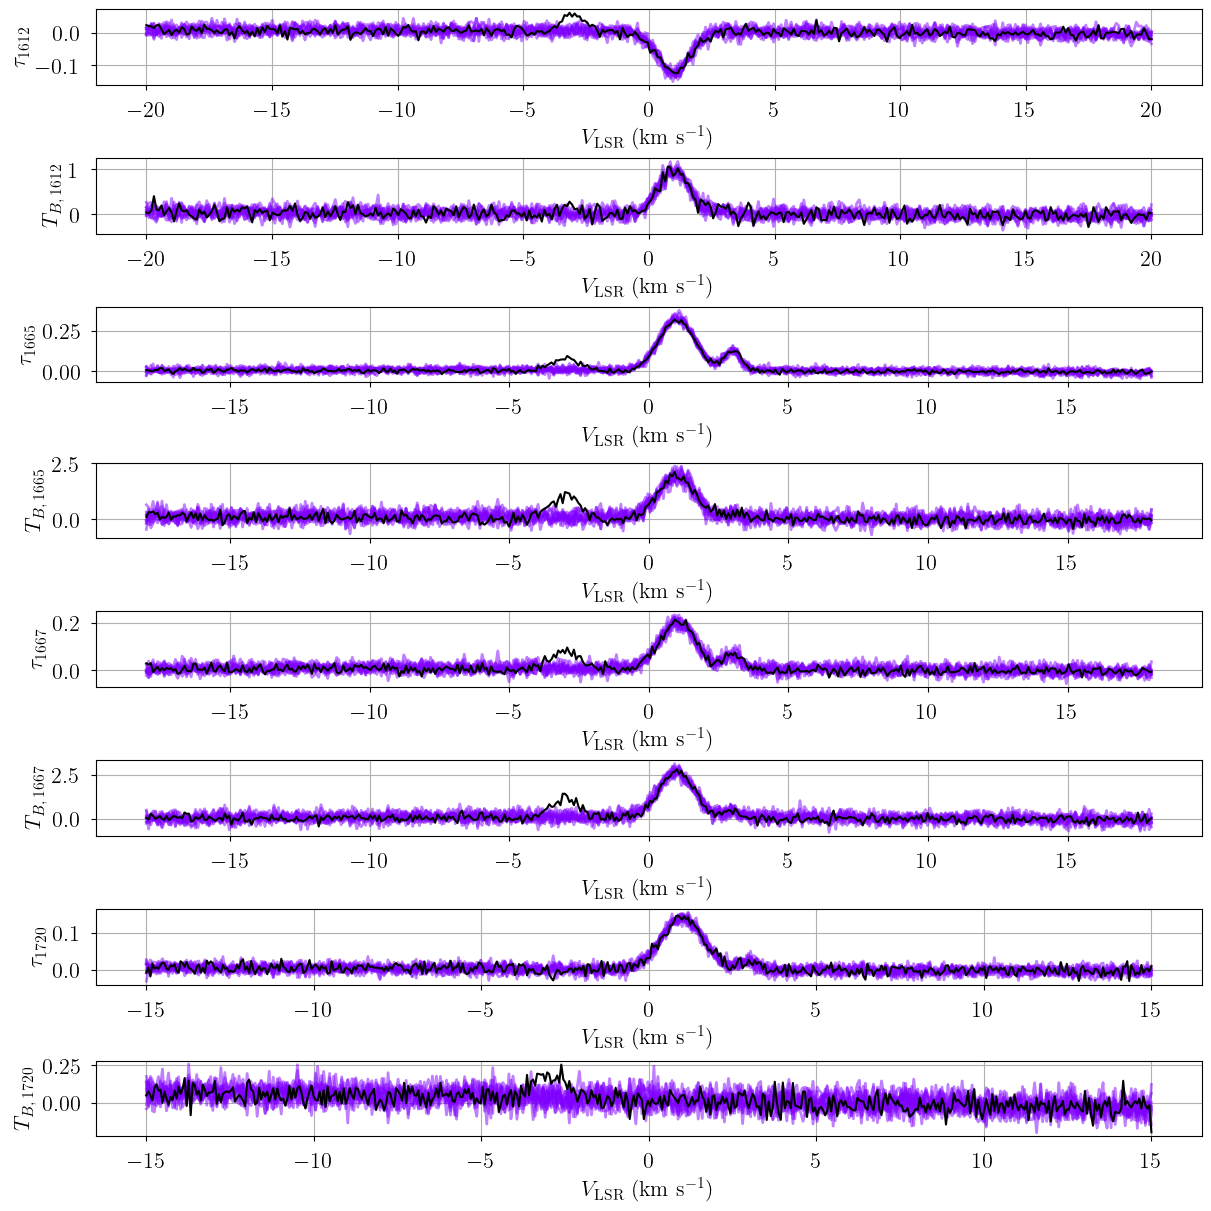

In [25]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

Notice that VI failed to identify the lowest velocity cloud!

## Posterior Sampling: MCMC

Since this model does not have a strong degeneracy between column density and excitation temperature, we can use the default `tune=1000` and `target_accept=0.8`.

In [26]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 11,487
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_tau_1612_norm, baseline_TB_1612_norm, baseline_tau_1665_norm, baseline_TB_1665_norm, baseline_tau_1667_norm, baseline_TB_1667_norm, baseline_tau_1720_norm, baseline_TB_1720_norm, log10_N_0_norm, inv_Tex_free_norm, fwhm_norm, velocity_norm, rms_tau_norm, rms_TB_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 288 seconds.


Runtime: 6.89 minutes


In [27]:
model.solve(p_threshold=0.9)

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 0 2]
Chain 1 order: [1 2 0]
Chain 2 order: [1 2 0]
Chain 3 order: [1 2 0]
Adopting (first) most common order: [1 2 0]


In [28]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_TB_1612_norm[0]    -0.259  0.036  -0.328   -0.195      0.001   
baseline_TB_1612_norm[1]    -0.450  0.093  -0.633   -0.282      0.001   
baseline_TB_1612_norm[2]     0.578  0.639  -0.588    1.794      0.009   
baseline_TB_1665_norm[0]    -0.368  0.026  -0.418   -0.318      0.000   
baseline_TB_1665_norm[1]    -0.413  0.063  -0.529   -0.296      0.001   
baseline_TB_1665_norm[2]     0.886  0.482  -0.028    1.746      0.007   
baseline_TB_1667_norm[0]    -0.323  0.023  -0.367   -0.283      0.000   
baseline_TB_1667_norm[1]    -0.180  0.051  -0.273   -0.086      0.001   
baseline_TB_1667_norm[2]    -0.217  0.413  -1.006    0.563      0.006   
baseline_TB_1720_norm[0]    -0.180  0.044  -0.259   -0.094      0.001   
baseline_TB_1720_norm[1]    -1.597  0.117  -1.816   -1.384      0.001   
baseline_TB_1720_norm[2]     0.856  0.721  -0.426    2.281      0.010   
baseline_tau_1612_norm[0]    0.137  0.030   0.080    0.192      0.000   
baseline_tau_1612_norm[1]   -0.476  0.072  -0.611   -0.344      0.001   
baseline_tau_1612_norm[2]   -0.042  0.535  -1.030    0.967      0.008   
baseline_tau_1665_norm[0]   -0.350  0.012  -0.374   -0.327      0.000   
baseline_tau_1665_norm[1]   -0.175  0.023  -0.219   -0.132      0.000   
baseline_tau_1665_norm[2]    0.162  0.222  -0.260    0.574      0.003   
baseline_tau_1667_norm[0]   -0.347  0.025  -0.393   -0.299      0.000   
baseline_tau_1667_norm[1]   -0.309  0.049  -0.406   -0.221      0.001   
baseline_tau_1667_norm[2]    0.086  0.441  -0.713    0.931      0.006   
baseline_tau_1720_norm[0]   -0.272  0.024  -0.316   -0.227      0.000   
baseline_tau_1720_norm[1]   -0.410  0.055  -0.513   -0.310      0.001   
baseline_tau_1720_norm[2]    0.123  0.444  -0.699    0.930      0.007   
fwhm[0]                      0.755  0.025   0.709    0.805      0.000   
fwhm[1]                      1.199  0.031   1.141    1.257      0.000   
fwhm[2]                      1.500  0.012   1.478    1.522      0.000   
fwhm_norm[0]                 0.755  0.025   0.709    0.805      0.000   
fwhm_norm[1]                 1.199  0.031   1.141    1.257      0.000   
fwhm_norm[2]                 1.500  0.012   1.478    1.522      0.000   
inv_Tex[1612, 0]             0.048  0.028  -0.004    0.102      0.000   
inv_Tex[1612, 1]             0.195  0.012   0.174    0.217      0.000   
inv_Tex[1612, 2]            -0.207  0.004  -0.215   -0.199      0.000   
inv_Tex[1665, 0]             0.215  0.016   0.186    0.245      0.000   
inv_Tex[1665, 1]             0.062  0.002   0.057    0.067      0.000   
inv_Tex[1665, 2]             0.102  0.001   0.100    0.104      0.000   
inv_Tex[1667, 0]             0.112  0.010   0.095    0.132      0.000   
inv_Tex[1667, 1]             0.058  0.003   0.052    0.063      0.000   
inv_Tex[1667, 2]             0.061  0.001   0.059    0.063      0.000   
inv_Tex[1720, 0]             0.272  0.031   0.211    0.327      0.000   
inv_Tex[1720, 1]            -0.066  0.010  -0.085   -0.048      0.000   
inv_Tex[1720, 2]             0.352  0.005   0.343    0.361      0.000   
inv_Tex_free[1612, 0]        0.048  0.028  -0.004    0.102      0.000   
inv_Tex_free[1612, 1]        0.195  0.012   0.174    0.217      0.000   
inv_Tex_free[1612, 2]       -0.207  0.004  -0.215   -0.199      0.000   
inv_Tex_free[1665, 0]        0.215  0.016   0.186    0.245      0.000   
inv_Tex_free[1665, 1]        0.062  0.002   0.057    0.067      0.000   
inv_Tex_free[1665, 2]        0.102  0.001   0.100    0.104      0.000   
inv_Tex_free[1667, 0]        0.112  0.010   0.095    0.132      0.000   
inv_Tex_free[1667, 1]        0.058  0.003   0.052    0.063      0.000   
inv_Tex_free[1667, 2]        0.061  0.001   0.059    0.063      0.000   
inv_Tex_free_norm[1612, 0]  -0.452  0.028  -0.504   -0.398      0.000   
inv_Tex_free_norm[1612, 1]  -0.305  0.012  -0.326   -0.283      0.000   
inv_Tex_free_norm[1612, 2]  -0.707  0.004  -0.715   -0.699      0.000   
inv_Tex_free_no

Sampling: [TB_1612, TB_1665, TB_1667, TB_1720, tau_1612, tau_1665, tau_1667, tau_1720]


Output()

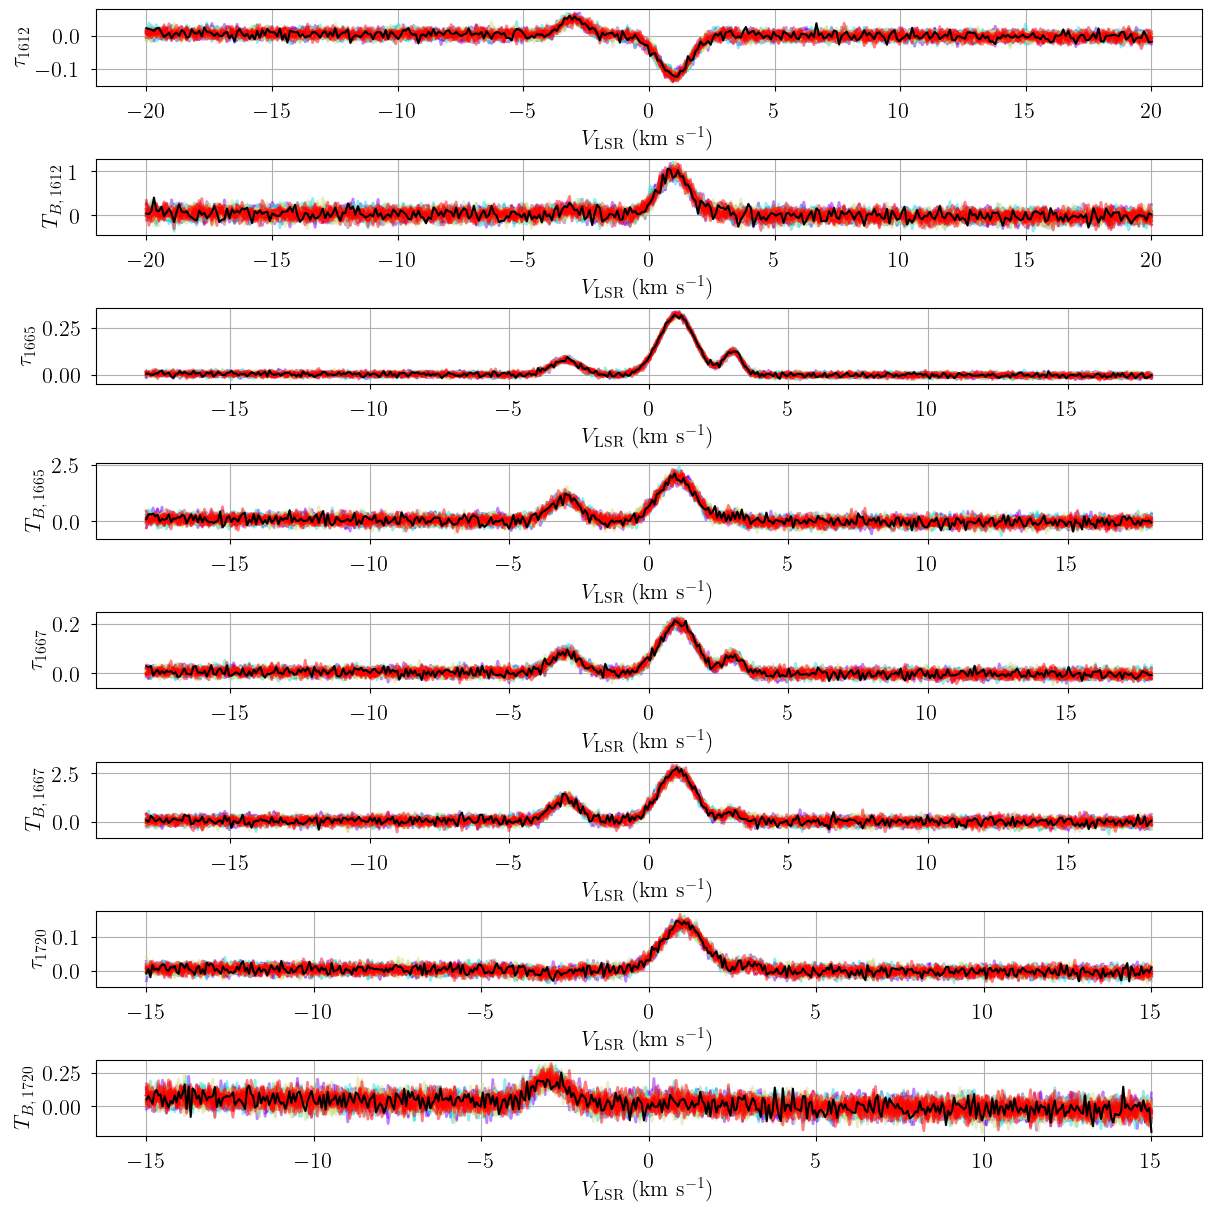

In [29]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

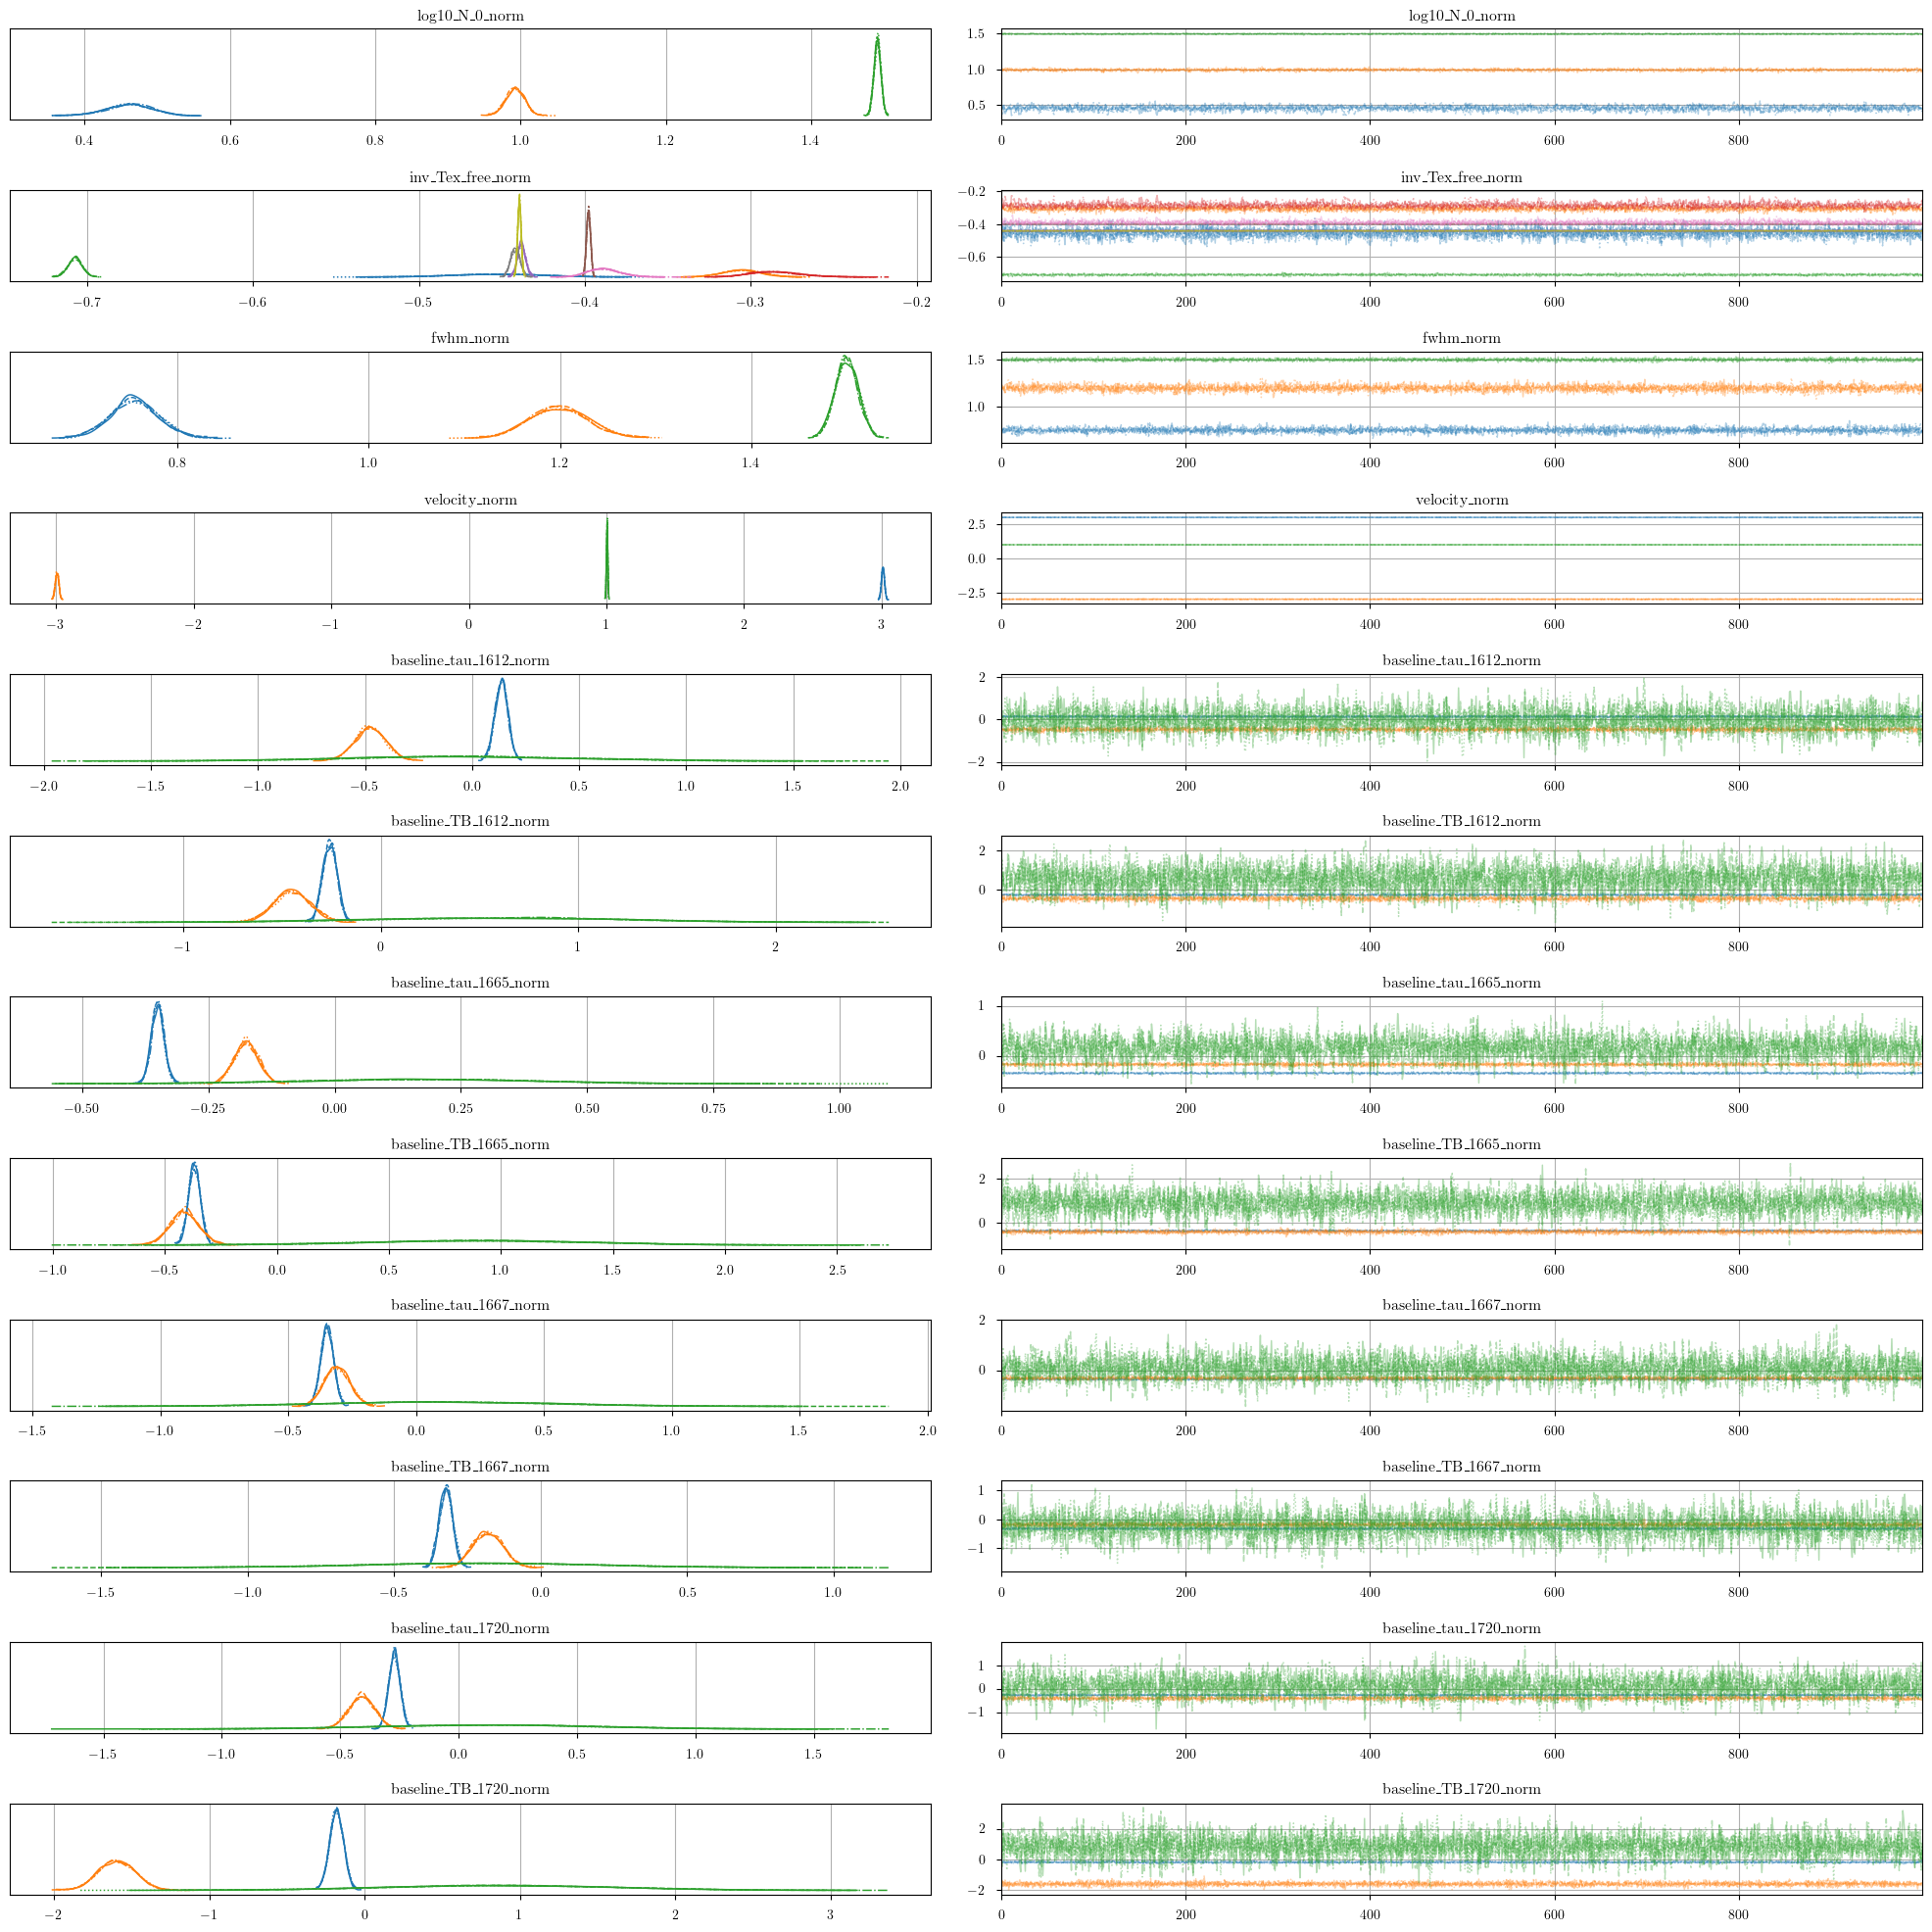

In [30]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
axes.ravel()[0].figure.set_size_inches(20, 20)
axes.ravel()[0].figure.tight_layout()

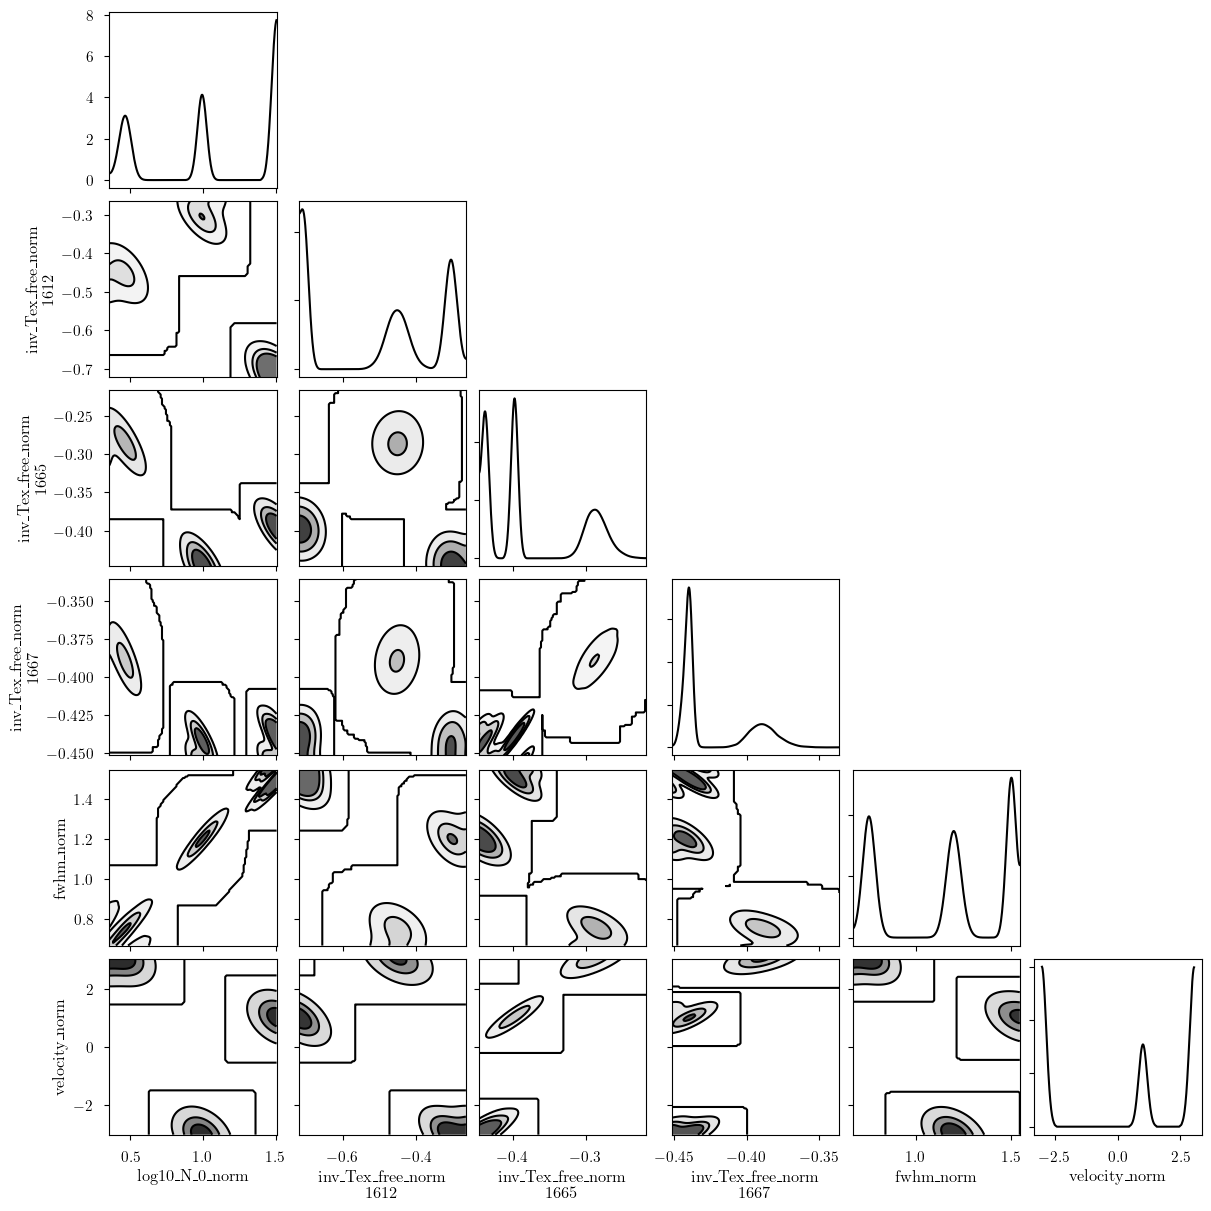

In [32]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)

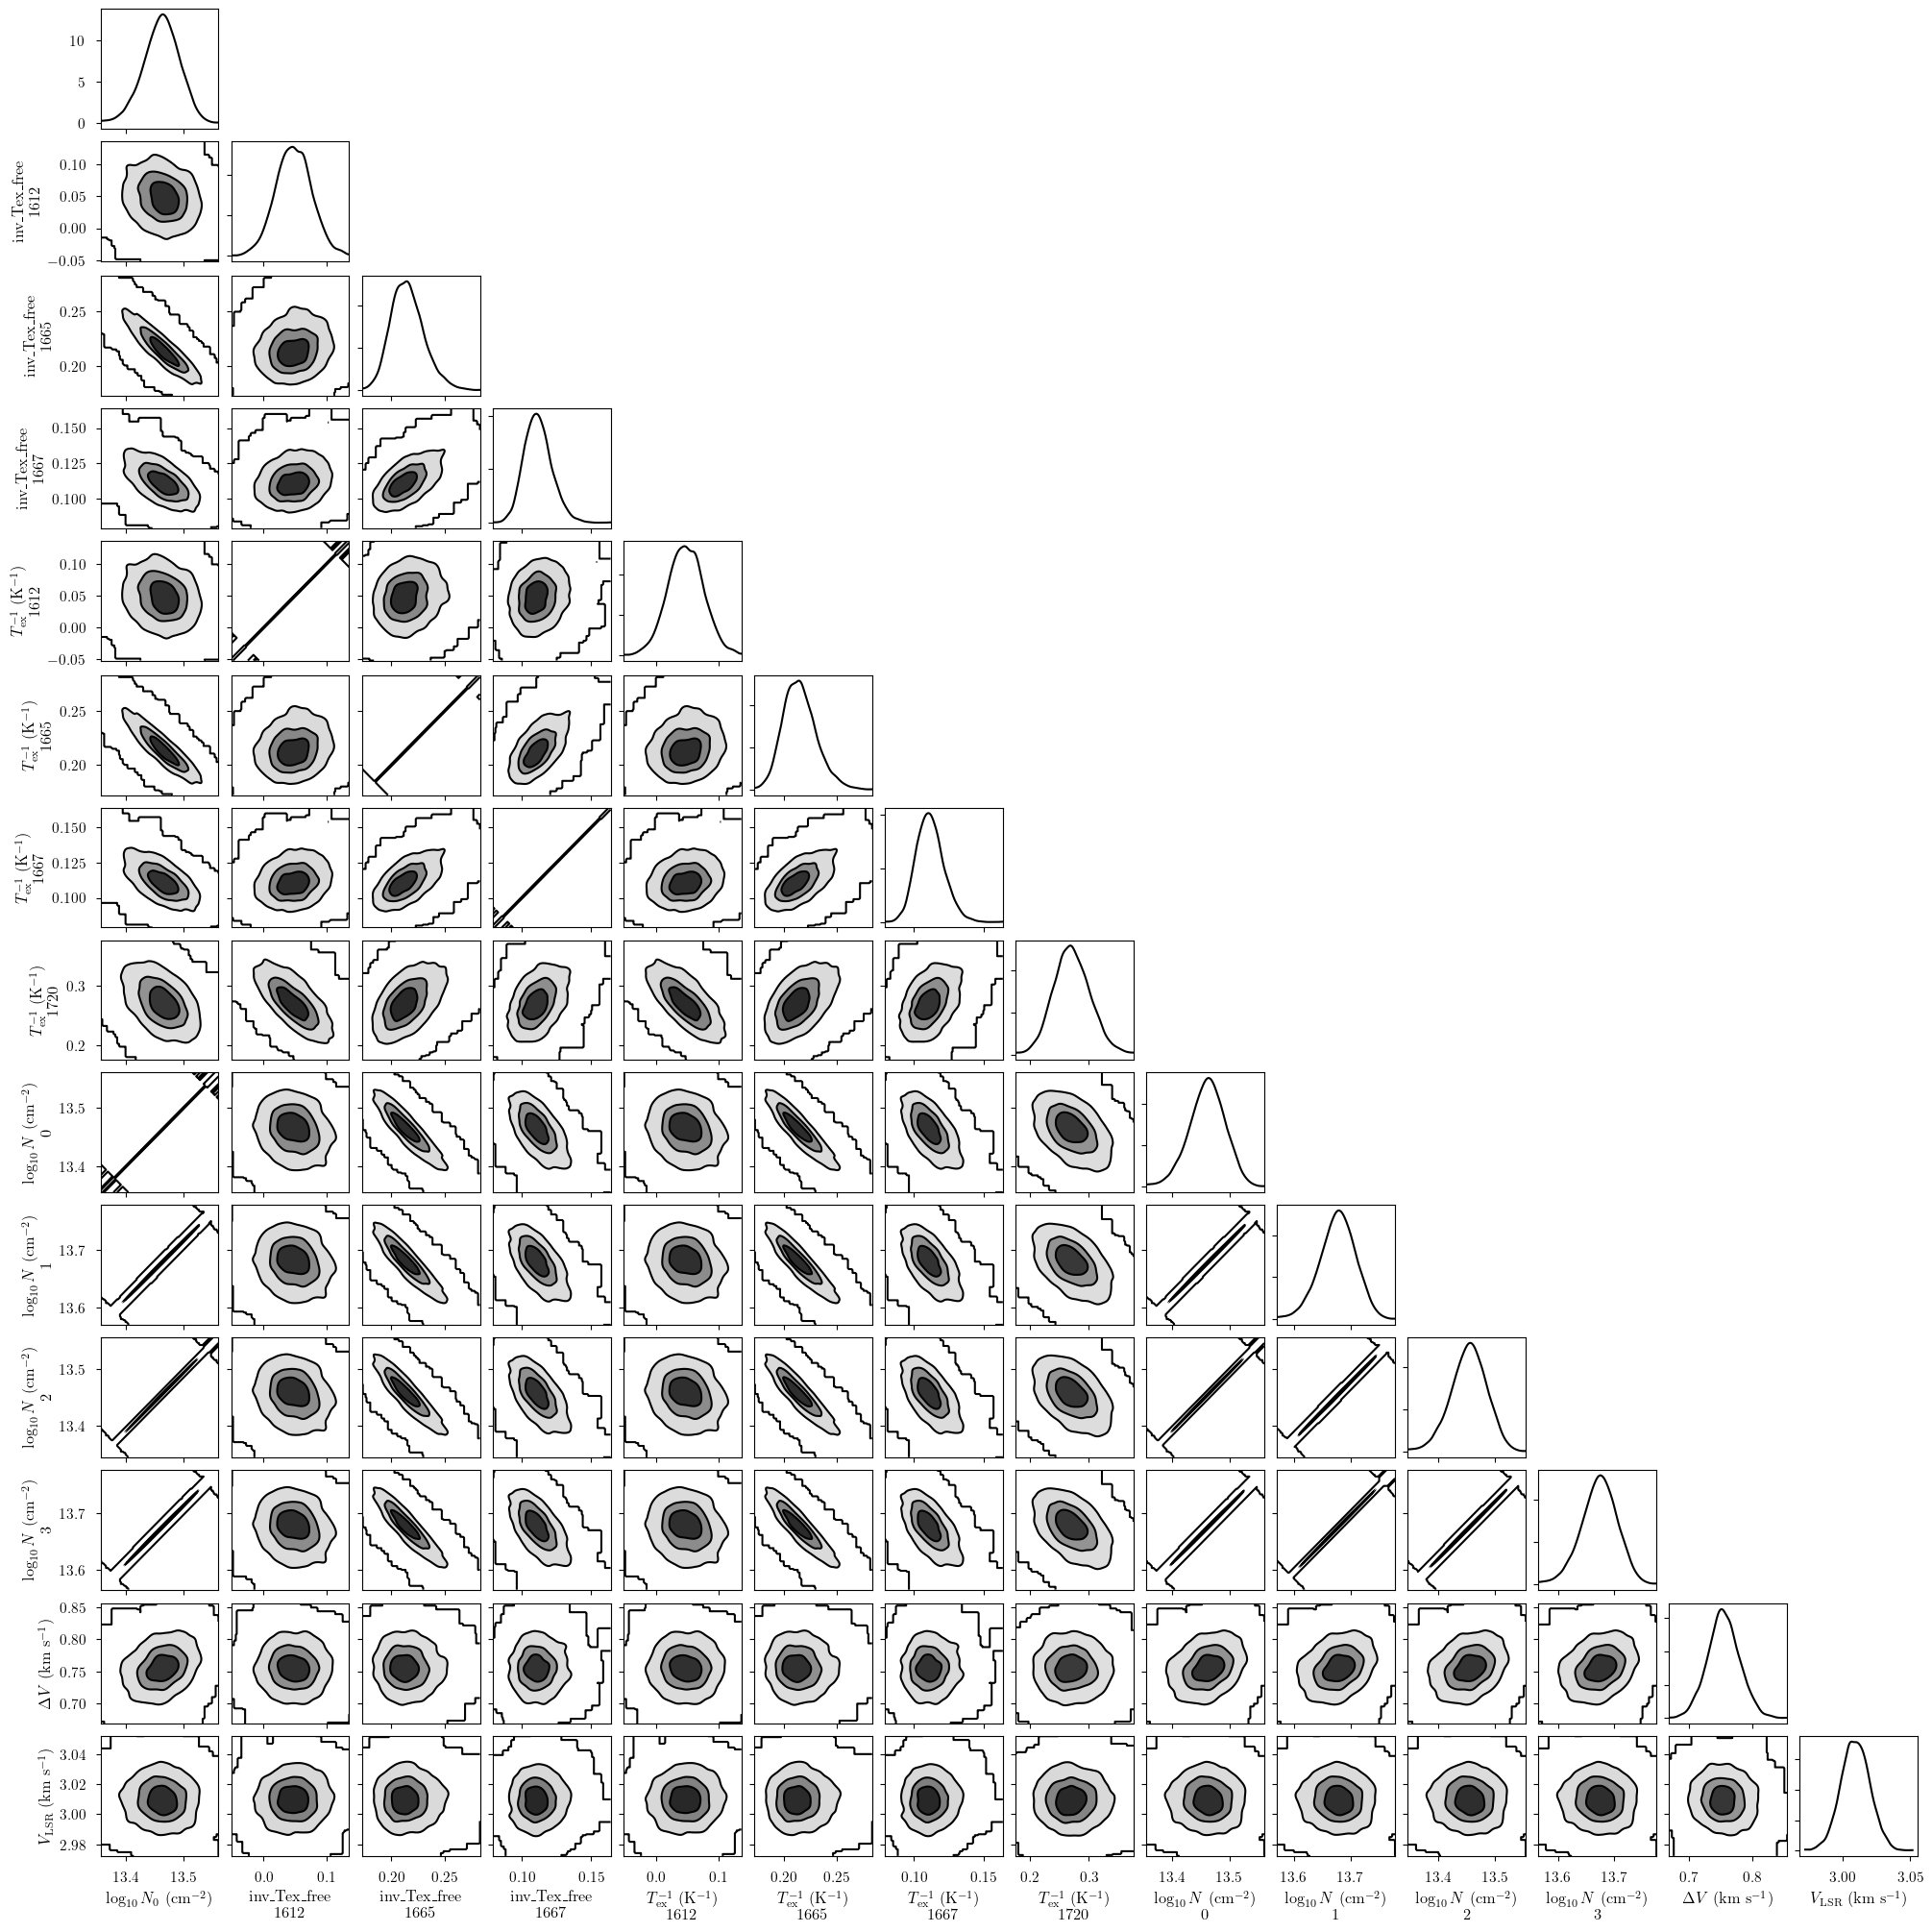

In [33]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(20, 20)

In [34]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
point_stats

BIC: -14226.05216728678


mean     sd  hdi_16%  hdi_84%
baseline_TB_1612_norm[0]    -0.259  0.036   -0.294   -0.222
baseline_TB_1612_norm[1]    -0.450  0.093   -0.544   -0.361
baseline_TB_1612_norm[2]     0.578  0.639    0.042    1.326
baseline_TB_1665_norm[0]    -0.368  0.026   -0.394   -0.342
baseline_TB_1665_norm[1]    -0.413  0.063   -0.479   -0.355
baseline_TB_1665_norm[2]     0.886  0.482    0.365    1.336
baseline_TB_1667_norm[0]    -0.323  0.023   -0.346   -0.301
baseline_TB_1667_norm[1]    -0.180  0.051   -0.234   -0.133
baseline_TB_1667_norm[2]    -0.217  0.413   -0.576    0.224
baseline_TB_1720_norm[0]    -0.180  0.044   -0.222   -0.135
baseline_TB_1720_norm[1]    -1.597  0.117   -1.718   -1.486
baseline_TB_1720_norm[2]     0.856  0.721    0.086    1.527
baseline_tau_1612_norm[0]    0.137  0.030    0.109    0.168
baseline_tau_1612_norm[1]   -0.476  0.072   -0.544   -0.403
baseline_tau_1612_norm[2]   -0.042  0.535   -0.595    0.465
baseline_tau_1665_norm[0]   -0.350  0.012   -0.362   -0.339
baseline_tau_1665_norm[1]   -0.175  0.023   -0.196   -0.149
baseline_tau_1665_norm[2]    0.162  0.222   -0.050    0.389
baseline_tau_1667_norm[0]   -0.347  0.025   -0.373   -0.324
baseline_tau_1667_norm[1]   -0.309  0.049   -0.358   -0.262
baseline_tau_1667_norm[2]    0.086  0.441   -0.393    0.486
baseline_tau_1720_norm[0]   -0.272  0.024   -0.297   -0.250
baseline_tau_1720_norm[1]   -0.410  0.055   -0.456   -0.347
baseline_tau_1720_norm[2]    0.123  0.444   -0.320    0.562
fwhm[0]                      0.755  0.025    0.731    0.780
fwhm[1]                      1.199  0.031    1.167    1.228
fwhm[2]                      1.500  0.012    1.488    1.511
fwhm_norm[0]                 0.755  0.025    0.731    0.780
fwhm_norm[1]                 1.199  0.031    1.167    1.228
fwhm_norm[2]                 1.500  0.012    1.488    1.511
inv_Tex[1612, 0]             0.048  0.028    0.020    0.075
inv_Tex[1612, 1]             0.195  0.012    0.183    0.206
inv_Tex[1612, 2]            -0.207  0.004   -0.211   -0.202
inv_Tex[1665, 0]             0.215  0.016    0.199    0.229
inv_Tex[1665, 1]             0.062  0.002    0.059    0.064
inv_Tex[1665, 2]             0.102  0.001    0.101    0.103
inv_Tex[1667, 0]             0.112  0.010    0.101    0.120
inv_Tex[1667, 1]             0.058  0.003    0.055    0.061
inv_Tex[1667, 2]             0.061  0.001    0.059    0.062
inv_Tex[1720, 0]             0.272  0.031    0.237    0.298
inv_Tex[1720, 1]            -0.066  0.010   -0.076   -0.056
inv_Tex[1720, 2]             0.352  0.005    0.347    0.356
inv_Tex_free[1612, 0]        0.048  0.028    0.020    0.075
inv_Tex_free[1612, 1]        0.195  0.012    0.183    0.206
inv_Tex_free[1612, 2]       -0.207  0.004   -0.211   -0.202
inv_Tex_free[1665, 0]        0.215  0.016    0.199    0.229
inv_Tex_free[1665, 1]        0.062  0.002    0.059    0.064
inv_Tex_free[1665, 2]        0.102  0.001    0.101    0.103
inv_Tex_free[1667, 0]        0.112  0.010    0.101    0.120
inv_Tex_free[1667, 1]        0.058  0.003    0.055    0.061
inv_Tex_free[1667, 2]        0.061  0.001    0.059    0.062
inv_Tex_free_norm[1612, 0]  -0.452  0.028   -0.480   -0.425
inv_Tex_free_norm[1612, 1]  -0.305  0.012   -0.317   -0.294
inv_Tex_free_norm[1612, 2]  -0.707  0.004   -0.711   -0.702
inv_Tex_free_norm[1665, 0]  -0.285  0.016   -0.301   -0.271
inv_Tex_free_norm[1665, 1]  -0.438  0.002   -0.441   -0.436
inv_Tex_free_norm[1665, 2]  -0.398  0.001   -0.399   -0.397
inv_Tex_free_norm[1667, 0]  -0.388  0.010   -0.399   -0.380
inv_Tex_free_norm[1667, 1]  -0.442  0.003   -0.445   -0.439
inv_Tex_free_norm[1667, 2]  -0.439  0.001   -0.441   -0.438
log10_N[0, 0]               13.461  0.031   13.432   13.493
log10_N[0, 1]               13.992  0.013   13.981   14.006
log10_N[0, 2]               14.491  0.005   14.487   14.496
log10_N[1, 0]               13.677  0.032   13.647   13.708
log10_N[1, 1]               14.219  0.013   14.207   14.232
log10_N[1, 2]               14.702  0.005   14.697   14.707
log10_N[2,